# Name: SIMRAN ANAND
# Registration number: 19BCD7243
## Lab 6 experiment
## Deep Learning CSE4006
## Submitted on: 5-11-2021
## Submitted to: Prof. BKSP Kumar raju Alluri

## **Question 1: Develop a web application using Streamlit to classify the flowers**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

C:\Users\simmu\.keras\datasets\flower_photos\roses\10090824183_d02c613f10_m.jpg


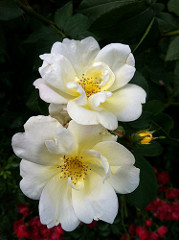

In [3]:
roses = list(data_dir.glob('roses/*'))
print(roses[0])
PIL.Image.open(str(roses[0]))

In [4]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


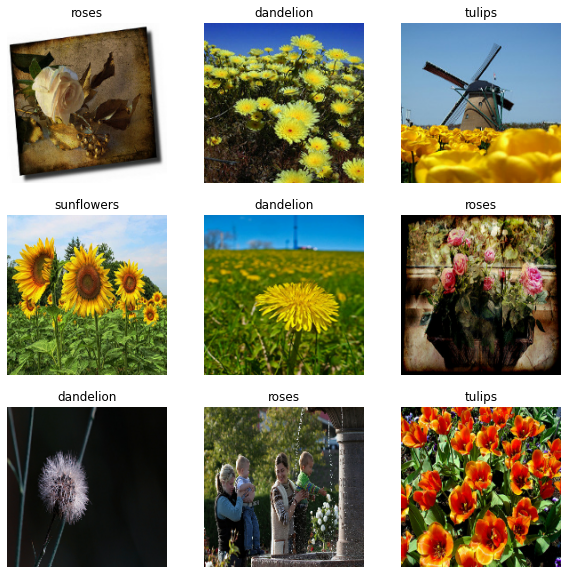

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:

num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [9]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


C:\Users\simmu\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


92/92 [==============================] - 29s 310ms/step - loss: 1.3831 - accuracy: 0.4091 - val_loss: 1.1012 - val_accuracy: 0.5586
Epoch 2/10
92/92 [==============================] - 28s 307ms/step - loss: 1.0193 - accuracy: 0.5984 - val_loss: 0.9551 - val_accuracy: 0.6444
Epoch 3/10
92/92 [==============================] - 28s 307ms/step - loss: 0.7920 - accuracy: 0.7047 - val_loss: 1.0497 - val_accuracy: 0.5817
Epoch 4/10
92/92 [==============================] - 28s 307ms/step - loss: 0.5871 - accuracy: 0.7800 - val_loss: 1.0564 - val_accuracy: 0.6362
Epoch 5/10
92/92 [==============================] - 28s 307ms/step - loss: 0.3697 - accuracy: 0.8638 - val_loss: 1.2605 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 32s 346ms/step - loss: 0.2191 - accuracy: 0.9305 - val_loss: 1.9828 - val_accuracy: 0.5858
Epoch 7/10
92/92 [==============================] - 36s 394ms/step - loss: 0.1598 - accuracy: 0.9499 - val_loss: 1.6112 - val_accuracy: 0.6294
Epoch 8/10

In [50]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [61]:
!pip install streamlit

In [63]:
%%writefile flower_app.py
import streamlit as st 
from PIL import Image
import tensorflow as tf 
from image_classifier import process_image, prediction_result
import time

st.set_option('deprecation.showfileUploaderEncoding', False)

st.title("Flower Classifier")

st.write("This app can predict flowers from five categories: Daisy, Rose, Sunflower, Tulip and Dandelion")

img = st.file_uploader("Please upload Image", type=["jpeg", "jpg", "png"])

# Display Image
st.write("Uploaded Image")
try:
	img = Image.open(img)
	st.image(img)	# display the image
	img = process_image(img)


	# Prediction
	model = tf.keras.models.load_model(
		"my_model2.hdf5")
	prediction = prediction_result(model, img)


	# Progress Bar
	my_bar = st.progress(0)
	for percent_complete in range(100):
		time.sleep(0.05)
		my_bar.progress(percent_complete + 1)

	# Output
	st.write("# Flower Type: {}".format(prediction["class"]))
	st.write("With Accuracy:", prediction["accuracy"],"%")
except AttributeError:
	st.write("No Image Selected")

Writing flower_app.py


In [65]:
import tensorflow as tf 
import numpy as np 
from PIL import Image, ImageOps	
import cv2


def process_image(img, img_size=(224, 224)):
    image = ImageOps.fit(img, img_size, Image.ANTIALIAS)
    # converts the image into numpy array
    image = np.asarray(image)
    # converts image from BGR color space to RGB
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resize = (cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC))/255.

    img_reshape = img_resize[np.newaxis,...]
    
    return img_reshape


def prediction_result(model, image_data):
  
  # Mapping prediction results to the Flower type
    classes = {0: "Daisy", 
               1: "Dandelion",
               2: "Rose",
               3: "Sunflower",
               4: "Tulip"}
    
    pred = model.predict(image_data)
    pred = pred.round(2)
    result = np.argmax(pred)
    
    prediction = {"class": classes[result],
                  "accuracy": np.round(np.max(pred) * 100, 2)}
    
    return prediction

In [52]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import pyarrow.lib as _lib

@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('my_model2.hdf5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload a flower photo", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(predictions)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Overwriting app.py


In [53]:
!pip install pyngrok

In [54]:
!ngrok authtoken 

Authtoken saved to configuration file: C:\Users\simmu/.ngrok2/ngrok.yml


In [55]:
get_ipython().system_raw('./ngrok http 8501 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
# this gives you the link on which your web app will be deployed

https://eaeb-45-118-74-70.ngrok.io


In [56]:
from pyngrok import ngrok

In [57]:
pub_url=ngrok.connect(port='8501')

In [58]:
pub_url

<NgrokTunnel: "http://bf46-45-118-74-70.ngrok.io" -> "http://localhost:80">

In [59]:
ngrok.kill()

### To deploy the web app on browser using Streamlit from Python terminal, execute the below command

In [ ]:
# streamlit run app.py 

# Question 2. Implement Text Summarization App using Streamlit



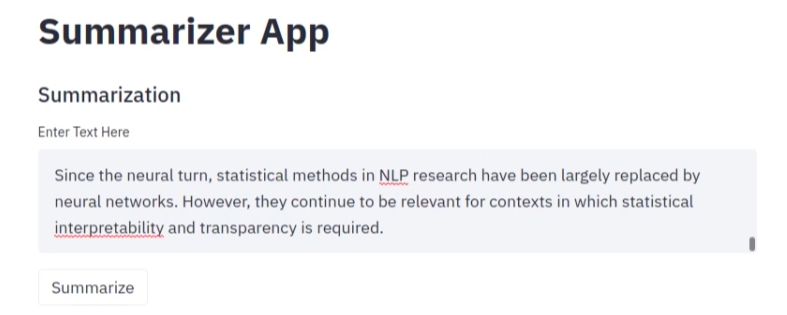

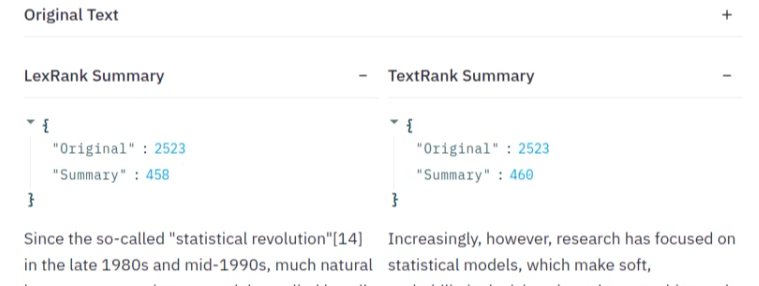

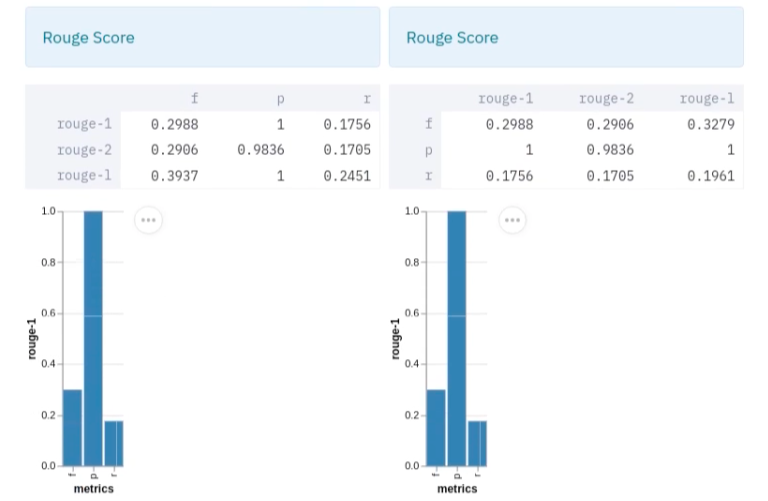

# Install gensim sumy rouge

# Question 3: Develop your own streamlit web app